# activations, gradients, batchnorm

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [14]:
# build vocab chars and mappings
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [18]:
# build the dataset
block_size = 3 # context length

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [40]:
# MLP revisited
n_emb = 10 # dimension of each char vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) # lookup table - each row is the embedding of a char (27x10)
W1 = torch.rand((n_emb * block_size, n_hidden), generator=g)
b1 = torch.rand(n_hidden, generator=g)
W2 = torch.rand((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.rand(vocab_size, generator=g) * 0

parameters = [C,W1,b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of total parameters of the model
for p in parameters:
  p.requires_grad = True

11897


In [41]:
# optimization from last time
max_steps = 20000
batch_size = 32 # in a batch 32 X,Y pairs will be used
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # picks batch_size random context from X
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embeddings of Xb
  embcat = emb.view(-1, n_emb * block_size) # reshape emb to (batch_size, n_emb * block_size)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 3.3116
   1000/  20000: 2.6525
   2000/  20000: 2.2794
   3000/  20000: 2.3115
   4000/  20000: 2.0593
   5000/  20000: 2.2440
   6000/  20000: 2.3969
   7000/  20000: 2.5467
   8000/  20000: 2.5349
   9000/  20000: 2.5987
  10000/  20000: 1.8770
  11000/  20000: 1.9923
  12000/  20000: 1.9507
  13000/  20000: 2.0721
  14000/  20000: 2.5754
  15000/  20000: 2.4059
  16000/  20000: 2.3185
  17000/  20000: 2.1628
  18000/  20000: 2.1766
  19000/  20000: 2.3755


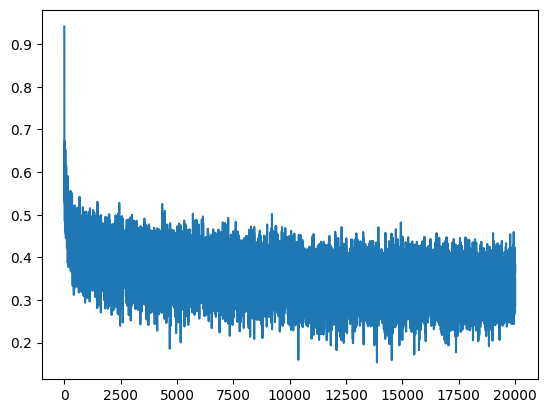

In [26]:
plt.plot(lossi)

In [39]:
# problem with the initialization
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -torch.log(probs[0])
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

In [42]:
@torch.no_grad() # decorator to diable gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_emb)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1559576988220215
val 2.1780924797058105


In [33]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out =[]
  context = [0] * block_size
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))


mora.
kayah.
seel.
ndyn.
aley.
threstadrlee.
adelynnelin.
shyanelle.
elieananar.
kayzion.
kasin.
shubergini.
jest.
jaireth.
koxtterofiu.
zayven.
kylynn.
ehs.
kayshusteyah.
hal.
